# RNN for 3D keypoint generation

## Build network with Keras

In [1]:
import warnings
warnings.filterwarnings('ignore')

import importlib
import time

import math
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.model_selection import train_test_split
import mdn
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

from data_utils import *

import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,os.path.join(parentdir, 'renderer')) 
#from common import *

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


### Parameters

In [4]:
#Dataset Generation
LOOK_BACK = 10
OUT_LOOK = 1
TAGS = ["impro"]
DANCER = ["maria"]
TRAJ_ON = False
TEST_SHARE = 0.05
NORMALIZE_Z = True
ADD_SD = False

#Model
LSTM_PARAMS = 32
MODEL_NAME = 'lstm-mdn-lea'

#Training
BATCH_SIZE = 64
EPOCHS = 3
VAL_SPLIT = 0.05

#Generation
TEMP = 1.0
RESCALE = True


BODY_SEGS = np.array([0.09205135, 0.38231316, 0.37099043, 0.09205053, 0.38036615,
        0.37101445, 0.20778206, 0.23425052, 0.0848529 , 0.10083677,
        0.10969228, 0.23822378, 0.19867802, 0.10972143, 0.23854321,
        0.1993194 ])

filename = str(DANCER)+"_traj_"+str(TRAJ_ON)+"_epochs_"+str(EPOCHS)+"_lookback_"+str(LOOK_BACK)+"_outlook_"+str(OUT_LOOK)+"_params_"+str(LSTM_PARAMS)+"_temp_"+str(TEMP)+"_RESCALE_"+str(RESCALE)+"_batchsize_"+str(BATCH_SIZE)+"_addInput_"+str(ADD_SD)

### Import keypoint sequences

In [5]:
#load data, you can filter with: dancers = ["maria", "raymond", ...] and tags = ["impro", ...]
X, y = get_training_data(dancers=DANCER, tags=TAGS,look_back = LOOK_BACK, target_length= OUT_LOOK, hip_correction = TRAJ_ON, normalize_z=NORMALIZE_Z, normalize_body=True, body_segments = BODY_SEGS)

# split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SHARE, shuffle= False, random_state=42)

print("data shape:")
print("X_train: ", np.shape(X_train))
print("y_train: ", np.shape(y_train))
print("X_test: ", np.shape(X_test))
print("y_test: ", np.shape(y_test))

Getting data for dancers:  ['maria']
Getting data for tags:  ['impro']
Normalizing body...
data shape:
X_train:  (171057, 10, 51)
y_train:  (171057, 1, 51)
X_test:  (9004, 10, 51)
y_test:  (9004, 1, 51)


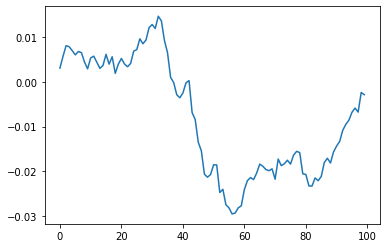

In [7]:
plt.plot(X_train[1000:1100,0,3])
plt.show()

In [4]:
diff = X_train[:,:,51]
print(diff.shape)
fig=plt.figure(figsize=(20, 5))
plt.plot(np.reshape(diff,(X_train.shape[0]*X_train.shape[1]))[90000:94000])

IndexError: index 51 is out of bounds for axis 2 with size 51

### build model

In [8]:
model = keras.Sequential()
model.add(layers.LSTM(LSTM_PARAMS, input_shape=(LOOK_BACK, X_train.shape[2]),  return_sequences=True))
model.add(layers.LSTM(LSTM_PARAMS, return_sequences=True))
model.add(layers.LSTM(OUT_LOOK*51))
model.add(layers.Dense(OUT_LOOK*51))
model.add(mdn.MDN(OUT_LOOK*51, 3))
model.compile(loss=custom_mixture_loss_func(OUT_LOOK*51,3), optimizer=keras.optimizers.Adam())
#model.compile(loss=keras.losses.MeanSquaredError(), optimizer=keras.optimizers.Adam())
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 32)            10752     
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 32)            8320      
_________________________________________________________________
lstm_2 (LSTM)                (None, 51)                17136     
_________________________________________________________________
dense (Dense)                (None, 51)                2652      
_________________________________________________________________
mdn (MDN)                    (None, 309)               16068     
Total params: 54,928
Trainable params: 54,928
Non-trainable params: 0
_________________________________________________________________


### Train model

Epoch 1/3
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
2673/2673 [==============================] - 200s 73ms/step - loss: -70.9012 - val_loss: -61.6959

Epoch 00001: val_loss improved from inf to -61.69592, saving model to models/lstm_mdn2-E01-VL-61.70.h5
Epoch 2/3
2673/2673 [==============================] - 194s 73ms/step - loss: -117.3758 - val_loss: -70.3446

Epoch 00002: val_loss improved from -61.69592 to -70.34464, saving model to models/lstm_mdn2-E02-VL-70.34.h5
Epoch 3/3
2673/2673 [==============================] - 194s 73ms/step - loss: -131.2322 - val_loss: -91.2353

Epoch 00003: val_loss improved from -70.34464 to -91.23526, saving model to models/lstm_mdn2-E03-VL-91.24.h5


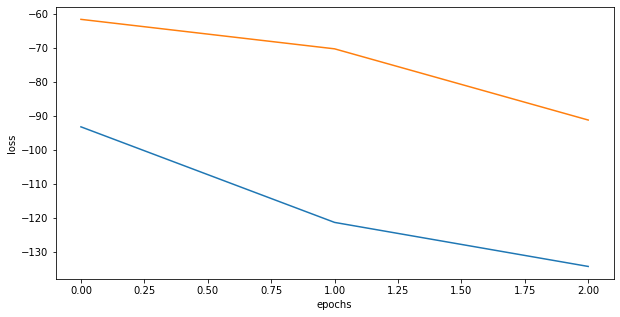

In [9]:

# Parameters
limit = int(np.floor(len(X_train)/BATCH_SIZE))*BATCH_SIZE


# Define callbacks
filepath="models/lstm_mdn2-E{epoch:02d}-VL{val_loss:.2f}.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, save_weights_only=True, verbose=1, save_best_only=True, mode='min')
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
callbacks = [keras.callbacks.TerminateOnNaN(), checkpoint, early_stopping]

history = model.fit(X, y, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=callbacks, validation_split=VAL_SPLIT)

# Save the Model
model.save('models/'+filename+'.h5')  # creates a HDF5 file of the model

# Plot the loss
%matplotlib inline
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### load model

In [6]:
model = tf.keras.models.load_model('models/'+filename+'.h5',custom_objects={'MDN': mdn.MDN, 'mdn_loss_func': custom_mixture_loss_func(51,3)}) 

OSError: SavedModel file does not exist at: models/['maria']_traj_False_epochs_3_lookback_10_outlook_1_params_32_temp_1.0_RESCALE_True_batchsize_64_addInput_False.h5/{saved_model.pbtxt|saved_model.pb}

### Generate sequence(s)

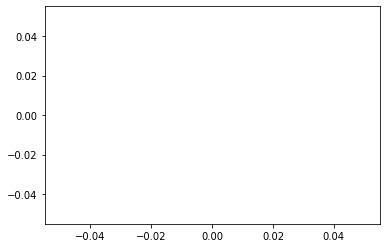

In [8]:
start_frame = 100
number_frames = 100
r = np.arange(0, 100, 100/(number_frames+LOOK_BACK))
SIN_SCALE = 0.1
if ADD_SD:
    extra_input = (np.sin(r*SIN_SCALE)+1)*0.2 + np.sin(r*np.sin(4)+1)*0.02 + 0.2
    #extra_input = np.sin(r*np.sin(1)+1)*0.001
else:
    extra_input = np.array([]) 
    
plt.plot(extra_input)
plt.show()

In [9]:

print('init: '+str(X_test[start_frame].shape))

longer_performance = generate_performance(model,X_test[start_frame][:,:51], steps_limit=number_frames, look_back=LOOK_BACK,temp = TEMP, hip_correction=TRAJ_ON, rescale_post=False, rescale_process=False, body_segments = BODY_SEGS)
print(longer_performance.shape)

#save to file in json format so that it can be used by 
save_seq_to_json(longer_performance, "../sequences/generated_sequence_"+filename+"_sin_"+str(SIN_SCALE)+".json", path_base_dir=os.path.abspath("./"))

init: (10, 51)


NameError: name 'model' is not defined

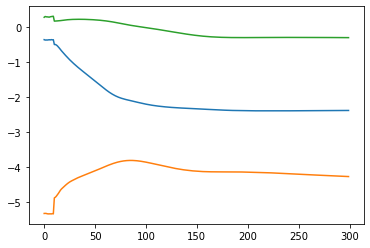

In [13]:
plt.plot(longer_performance[:300,2,:])
plt.show()

In [4]:
performance = X_train.reshape((X_train.shape[0],17,3))[2000:4000]
filename = 'traindata.json'
path_base_dir=os.path.abspath("./")

jsonData = {}
jsonData['bones'] = {
    'rightLeg': [0,1,2,3],
    'leftLeg' : [0,4,5,6],
    'spine': [0,7,8],
    'rightArm':[8,14,15,16],
    'leftArm':[8,11,12,13],
    'head':[8,9,10]
}

jsonData['frames'] = {}
frameIdx = 0;
for frame in performance:
    jsonData['frames'][frameIdx] = []
    for point in frame:
        jsonData['frames'][frameIdx].append([point[0].astype(float), point[1].astype(float), point[2].astype(float)])
    frameIdx += 1
with open(os.path.join(path_base_dir, filename), 'w') as outfile:
    json.dump(jsonData, outfile)